# Задача: Сопоставление текста и изображения 

## Описание проекта

Вы работаете в фотохостинге «Со Смыслом» (“With Sense”), где фотографы размещают снимки с описаниями. Уникальность сервиса — описание фото могут добавлять все пользователи. 

Например:
⎢ A hiker poses for a picture in front of stunning mountains and clouds.

Ваш отдел тестирует поиск референсных фото по текстовому запросу. Пользователь вводит описание, например:
⎢ A man is crossing a mountain pass on a metal bridge.

Сервис подбирает соответствующие снимки.

## Цель
создать PoC (Proof of Concept) для защиты проекта перед руководством. Требуется разработать модель, которая сопоставляет текст и изображение, выдавая степень их соответствия (0-1).

Юридические ограничения

В ряде стран нельзя показывать контент, связанный с детьми, без разрешения родителей. В таких случаях вместо изображений отображается дисклеймер:
⎢ This image is unavailable in your country in compliance with local laws.

В рамках PoC этот функционал недоступен, поэтому данные нужно заранее очистить. При тестировании модели при запросе с запрещённым контентом должен отображаться дисклеймер.

## Описание данных

В файле train_dataset.csv находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. 
Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке train_images содержатся изображения для тренировки модели.

В файле CrowdAnnotations.tsv  — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:
- Имя файла изображения.
- Идентификатор описания.
- Доля людей, подтвердивших, что описание соответствует изображению.
- Количество человек, подтвердивших, что описание соответствует изображению.
- Количество человек, подтвердивших, что описание не соответствует изображению.

В файле ExpertAnnotations.tsv  — данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:
- Имя файла изображения.
- Идентификатор описания.
- 3, 4, 5 — оценки трёх экспертов. 

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью. 

В файле test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке test_images содержатся изображения для тестирования модели.

При решении задачи используйте только один фреймворк  Pytorch или Keras.

# Загрузка библиотек и функции

In [1]:
# Стандартные библиотеки Python
import os
import re
import zipfile
import pickle
import warnings
from collections import Counter

# Библиотеки для работы с данными
import pandas as pd
import numpy as np

# Визуализация
import matplotlib.pyplot as plt

# Работа с изображениями
from PIL import Image

# NLP (обработка естественного языка)
import spacy
from nltk.stem import WordNetLemmatizer
from gensim.downloader import load

# TensorFlow и машинное обучение
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense, 
    GlobalAveragePooling2D, 
    Dropout, 
    BatchNormalization
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Библиотеки для машинного обучения (scikit-learn)
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import (
    cross_val_score,
    GroupShuffleSplit,
    GridSearchCV
)
from sklearn.preprocessing import StandardScaler

# Работа с HTTP-запросами
import requests

In [2]:
warnings.filterwarnings("ignore")

## Константы

In [3]:
CENZ = [
    'teenage', 'baby', 'child', 'teenager', 'girl', 'boy', 'kid', 'toddler', 'infant', 'adolescent', 
    'minor', 'preteen', 'juvenile', 'youth', 'pediatric', 'schoolchild', 'kindergartner', 'youngster', 
    'childish', 'childhood', 'pubescent', 'prepubescent', 'teen', 'little one', 'tike', 'sprout', 
    'bambino', 'littler', 'young', 'rugrat', 'nipper', 'moppet', 'whippersnapper', 'brat', 'toddlerhood',
    'pup', 'minikin', 'underage'
] # список широкий - помогал GPT формировать

EXPERT_WEIGHT = 0.6  # Вес для экспертной оценки
CROWD_WEIGHT = 0.4   # Вес для оценки людей

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Загрузка данных и первая их оценка

In [4]:
# url = "https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip"
# filename = "dsplus_integrated_project_4.zip"

# response = requests.get(url, stream=True)
# with open(filename, "wb") as file:
#     file.write(response.content)

# with zipfile.ZipFile(filename, 'r') as zip_ref:
#     zip_ref.extractall()  

# if 'to_upload' in os.listdir("."):
#     # Получаем список содержимого папки 'to_upload'
#     to_upload_contents = os.listdir('./to_upload')
#     print(to_upload_contents)
# else:
#     print("'to_upload' не найдена в текущей директории")

Все данные скачаны и соотвествуют описани задачи. 

In [5]:
current_dir = os.getcwd()
upload_dir = os.path.join(current_dir, 'to_upload')

df_train = pd.read_csv(os.path.join(upload_dir, 'train_dataset.csv'))
df_crowd = pd.read_csv(os.path.join(upload_dir, 'CrowdAnnotations.tsv'), sep='\t', 
                       names=['image', 'query_id', 'share_pos', 'count_pos', 'count_neg'])
df_expert = pd.read_csv(os.path.join(upload_dir, 'ExpertAnnotations.tsv'), sep='\t', 
                        names=['image', 'query_id', 'first', 'second', 'third'])
df_queries = pd.read_csv(os.path.join(upload_dir, 'test_queries.csv'), sep='|', index_col=0)
df_images = pd.read_csv(os.path.join(upload_dir, 'test_images.csv'), sep='|')

In [6]:
print("Датасет train")
display(df_train.head())
display(df_train.info())

print("Датасет CrowdAnnotations")
display(df_crowd.head())
display(df_crowd.info())

print("Датасет ExpertAnnotations")
display(df_expert.head())
display(df_expert.info())

print("Датасет test_queries")
display(df_queries.head())
display(df_queries.info())

print("Датасет test_images")
display(df_images.head())
display(df_images.info())

Датасет train


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

Датасет CrowdAnnotations


image                     query_id  share_pos  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0   

   count_pos  count_neg  
0          3          0  
1          0          3  
2          0          3  
3          0          3  
4          0          3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   image      47830 non-null  object 
 1   query_id   47830 non-null  object 
 2   share_pos  47830 non-null  float64
 3   count_pos  47830 non-null  int64  
 4   count_neg  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

Датасет ExpertAnnotations


image                     query_id  first  second  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1       1   

   third  
0      1  
1      2  
2      2  
3      2  
4      2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   first     5822 non-null   int64 
 3   second    5822 non-null   int64 
 4   third     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


None

Датасет test_queries


query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


None

Датасет test_images


image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes


None

- Пропусков нет во всех датасетах

In [7]:
print(f"Количество уникальных фото в тесте: {df_train['image'].nunique()}.")

Количество уникальных фото в тесте: 1000.


In [8]:
print("Средние оценки ExpertAnnotations:")
print(df_expert[['first', 'second', 'third']].mean())

Средние оценки ExpertAnnotations:
first     1.436620
second    1.624356
third     1.881999
dtype: float64


In [9]:
print("Средние оценки CrowdAnnotations:")
print(df_crowd[['share_pos', 'count_pos', 'count_neg']].mean())

Средние оценки CrowdAnnotations:
share_pos    0.068786
count_pos    0.208488
count_neg    2.820155
dtype: float64


In [10]:
crowd_pairs = set(zip(df_crowd['image'], df_crowd['query_id']))
expert_pairs = set(zip(df_expert['image'], df_expert['query_id']))
common_pairs = crowd_pairs & expert_pairs

print("Количество пар картинка-текст с оценками от людей и экспертов:", len(common_pairs))

Количество пар картинка-текст с оценками от людей и экспертов: 2329


In [11]:
train_queries = set(df_train['query_text'])
test_queries = set(df_queries['query_text'])

print('Уникальных описаний в трейне:', len(train_queries))
print('Уникальных описаний в тесте:', len(test_queries))
print('Уникальных описаний которые и там и там:', len(train_queries & test_queries))

Уникальных описаний в трейне: 977
Уникальных описаний в тесте: 500
Уникальных описаний которые и там и там: 0


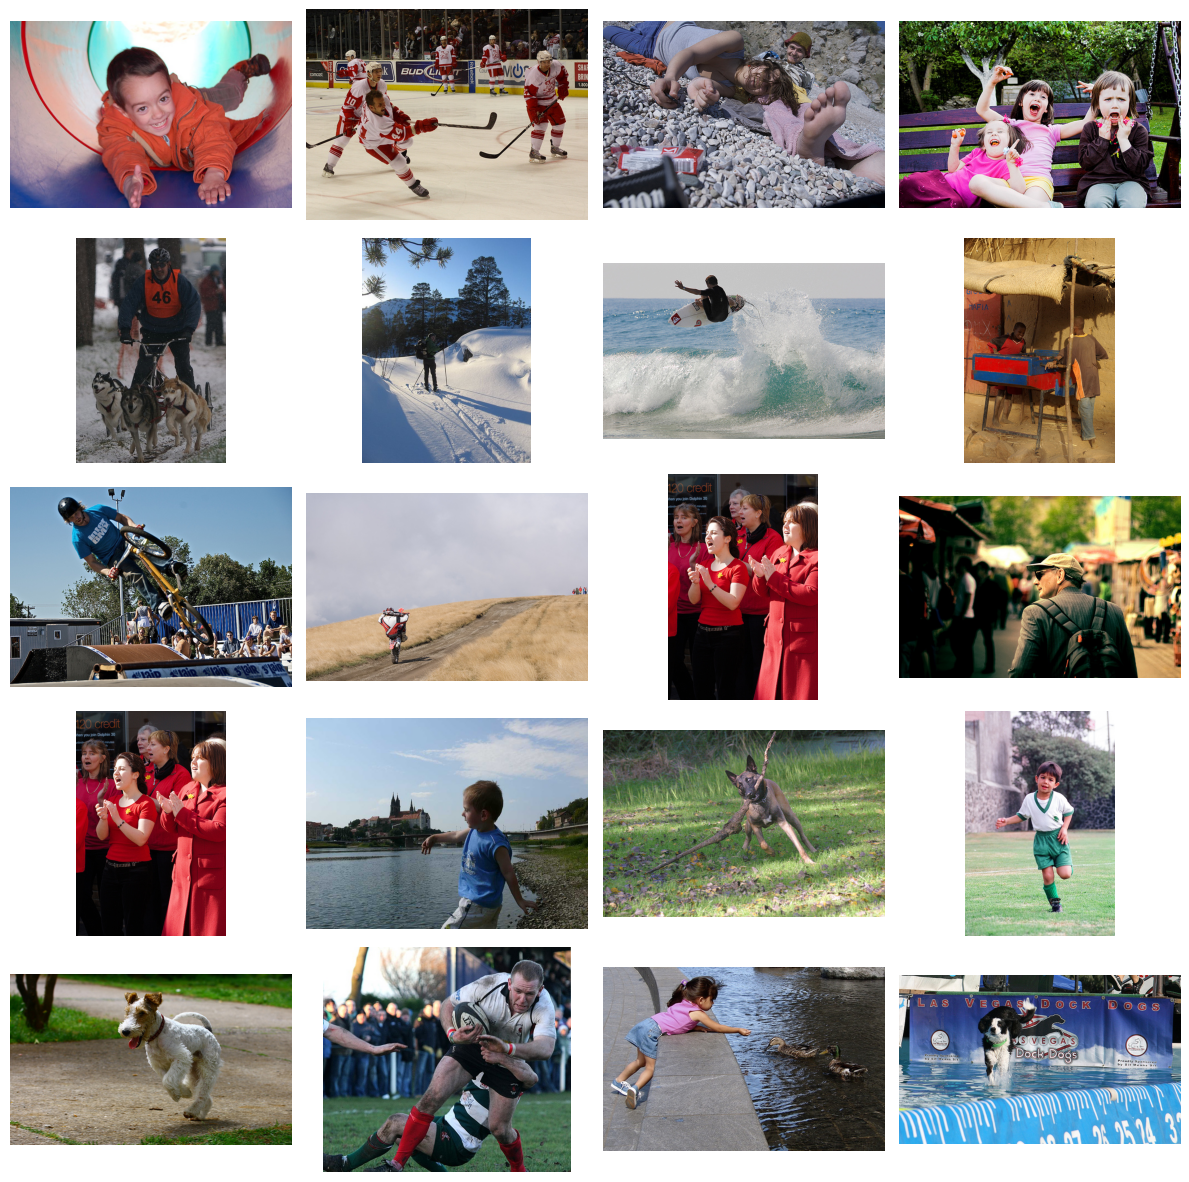

In [12]:
samples_train = list(df_train['image'].sample(10))
samples_test = list(df_queries['image'].sample(10))

def display_images(samples, axes, start_idx, base_path):
    for i, img_name in enumerate(samples, start=start_idx):
        image_path = os.path.join(base_path, img_name)  
        image = Image.open(image_path)  
        axes[i].imshow(image)
        axes[i].axis('off')

fig, axes = plt.subplots(5, 4, figsize=(12, 12))
axes = axes.ravel()

# Покажем тренировочные изображения
display_images(samples_train, axes, start_idx=0, base_path=os.path.join(upload_dir, 'train_images'))
# Покажем тестовые изображения
display_images(samples_test, axes, start_idx=10, base_path=os.path.join(upload_dir, 'test_images'))

plt.tight_layout()
plt.show()

- У нас много изображений детей - важность отсеивания для соблюения законов велика!

# Агрегируем оценки

In [13]:
def expert_aggregate(row) -> object:
    '''Агрегируем экспертную оценку усреднением ответов и сведением к диапазону [0, 1].'''

    # Собираем все оценки в список
    votes = [row['first'], row['second'], row['third']]
    
    # Если все оценки разные, усредняем
    if len(set(votes)) == 3:
        row['expert_score'] = np.mean(votes) / 3
    else:
        # Иначе применяем голосование (берём наиболее частую оценку)
        most_common_vote = Counter(votes).most_common(1)[0][0]
        row['expert_score'] = (most_common_vote - 1) / 3

    return row

df_expert = df_expert.apply(expert_aggregate, axis=1)
df_expert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         5822 non-null   object 
 1   query_id      5822 non-null   object 
 2   first         5822 non-null   int64  
 3   second        5822 non-null   int64  
 4   third         5822 non-null   int64  
 5   expert_score  5822 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 273.0+ KB


In [14]:
df_expert.head(10)

image                     query_id  first  second  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1       1   
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2      1       1   
6  1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2      1       1   
7  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2      1       1   
8   106490881_5a2dd9b7bd.jpg  1425069308_488e5fcf9d.jpg#2      1       1   
9   106490881_5a2dd9b7bd.jpg  1714316707_8bbaa2a2ba.jpg#2      2       2   

   third  expert_score  
0      1      0.000000  
1      2      0.000000  
2      2      0.000000  
3      2      0.333333  
4      2      0.000000  
5      1      0.000000  
6      1      0.000000  
7      2      0.000000  
8      1      0.000000  
9      2      0.333333

Объеденим оценки

In [15]:
df_scores = pd.merge(df_expert, df_crowd, how='outer', on=['image', 'query_id'])

display(df_scores.head())
display(df_scores.info())

image                     query_id  first  second  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2    NaN     NaN   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2    NaN     NaN   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2    NaN     NaN   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2    NaN     NaN   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2    NaN     NaN   

   third  expert_score  share_pos  count_pos  count_neg  
0    NaN           NaN        1.0        3.0        0.0  
1    NaN           NaN        0.0        0.0        3.0  
2    NaN           NaN        0.0        0.0        3.0  
3    NaN           NaN        0.0        0.0        3.0  
4    NaN           NaN        0.0        0.0        3.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         51323 non-null  object 
 1   query_id      51323 non-null  object 
 2   first         5822 non-null   float64
 3   second        5822 non-null   float64
 4   third         5822 non-null   float64
 5   expert_score  5822 non-null   float64
 6   share_pos     47830 non-null  float64
 7   count_pos     47830 non-null  float64
 8   count_neg     47830 non-null  float64
dtypes: float64(7), object(2)
memory usage: 3.5+ MB


None

Правила агрегации:
- Если оценка эксперта (expert_score) отсутствует (NaN), используется только оценка людей (share_pos).
- Если оценка людей отсутствует (NaN), используется только оценка эксперта.
- Если и то, и другое присутствует, итоговая оценка вычисляется как взвешенная сумма: 60% от оценки эксперта и 40% от оценки людей.

In [16]:
df_scores['score'] = np.where(np.isnan(df_scores['expert_score']),
                              df_scores['share_pos'],  # Если оценка эксперта (expert_score) отсутствует (NaN), используется только оценка людей (share_pos).
                              np.where(np.isnan(df_scores['share_pos']),
                                       df_scores['expert_score'],  # Если оценка людей отсутствует (NaN), используется только оценка эксперта.
                                       df_scores['expert_score'] * EXPERT_WEIGHT + df_scores['share_pos'] * CROWD_WEIGHT))  # Взвешиваем если обе оценки есть


df_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         51323 non-null  object 
 1   query_id      51323 non-null  object 
 2   first         5822 non-null   float64
 3   second        5822 non-null   float64
 4   third         5822 non-null   float64
 5   expert_score  5822 non-null   float64
 6   share_pos     47830 non-null  float64
 7   count_pos     47830 non-null  float64
 8   count_neg     47830 non-null  float64
 9   score         51323 non-null  float64
dtypes: float64(8), object(2)
memory usage: 3.9+ MB


In [17]:
# уберем лишние колокни
df_scores.drop(columns=["first", "second", "third", "expert_score", "share_pos", "count_pos", "count_neg"], inplace=True)
df_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     51323 non-null  object 
 1   query_id  51323 non-null  object 
 2   score     51323 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.2+ MB


In [18]:
df_train = df_train.merge(df_scores, how="outer", on=["image", "query_id"])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51323 non-null  object 
 1   query_id    51323 non-null  object 
 2   query_text  5822 non-null   object 
 3   score       51323 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.6+ MB


In [19]:
# заполним пропуски в описаниях query_text модой. 
def fill_with_mode(group):
    # Находим моду в группе (если она есть)
    mode_value = group['query_text'].mode()
    if not mode_value.empty:  # Если мода существует, используем её
        group['query_text'] = group['query_text'].fillna(mode_value.iloc[0])
    return group

df_train = df_train.groupby("query_id").apply(fill_with_mode)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 51323 entries, ('1056338697_4f7d7ce270.jpg#2', 0) to ('997722733_0cb5439472.jpg#2', 51322)
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51323 non-null  object 
 1   query_id    51323 non-null  object 
 2   query_text  50214 non-null  object 
 3   score       51323 non-null  float64
dtypes: float64(1), object(3)
memory usage: 4.3+ MB


In [20]:
# удалим те строки где нет описаний 
df_train.dropna(inplace=True, ignore_index=True)
df_train.info()
df_train.sample(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50214 entries, 0 to 50213
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       50214 non-null  object 
 1   query_id    50214 non-null  object 
 2   query_text  50214 non-null  object 
 3   score       50214 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.5+ MB


image                     query_id  \
47890  2644430445_47c985a2ee.jpg   535830521_aa971319fc.jpg#2   
2210   2419221084_01a14176b4.jpg  1389264266_8170bc1c54.jpg#2   
16171   327415627_6313d32a64.jpg   261490838_2f3ac98b12.jpg#2   
3882   3220126881_b0a4f7cccb.jpg   160792599_6a7ec52516.jpg#2   
26087  1808370027_2088394eb4.jpg  3106026005_473a7b1c8c.jpg#2   
23414  3143155555_32b6d24f34.jpg  2991994415_504d1c0a03.jpg#2   
16382  2594902417_f65d8866a8.jpg   263854883_0f320c1562.jpg#2   
40085  3427118504_93126c83e0.jpg  3591462960_86045906bd.jpg#2   
36896   387830531_e89c192b92.jpg   348380010_33bb0599ef.jpg#2   
16765  2431832075_00aa1a4457.jpg  2654514044_a70a6e2c21.jpg#2   
4829   3544793763_b38546a5e8.jpg  1836335410_de8313a64e.jpg#2   
5889    245252561_4f20f1c89e.jpg  2078311270_f01c9eaf4c.jpg#2   
10993   745880539_cd3f948837.jpg  2410320522_d967f0b75c.jpg#2   
14761  1352410176_af6b139734.jpg  2559921948_06af25d566.jpg#2   
2807   1659358141_0433c9bf99.jpg   143688283_a96ded20f1.jpg#2   
36762  3108197858_441ff38565.jpg  3482062809_3b694322c4.jpg#2   
11761   917574521_74fab68514.jpg  2445283938_ff477c7952.jpg#2   
43352  3506560025_8d0f4f9ac4.jpg  3727752439_907795603b.jpg#2   
45794  2354540393_a149722680.jpg   470373679_98dceb19e7.jpg#2   
24590  3315616181_15dd137e27.jpg  3042380610_c5ea61eef8.jpg#2   

                                              query_text  score  
47890  A woman holds a newspaper that says " Real cha...    0.0  
2210                 Two girls walking down the street .    0.0  
16171  A dog chasing a deer in a field of yellow flow...    0.0  
3882   Five people standing in front of a body of wat...    0.0  
26087  A man wearing an orange cap sits on a white be...    0.0  
23414                 two girls dress up for halloween .    0.0  
16382             Two small dogs run through the grass .    0.0  
40085  A rodeo rider gets tossed up into the air by a...    0.0  
36896  A brown dog with a tennis ball its mouth rolli...    0.0  
16765  A brown dog with its front paws off the ground...    0.0  
4829   Man dressed up in black and brown and holding ...    0.0  
5889         Two women crossing the street on a cold day    0.0  
10993   Large dog plays with two smaller dogs on grass .    0.0  
14761         a little boy at the beach with a surfboard    0.0  
2807   A man in a white shirt and helmet is using cli...    0.0  
36762  A woman posing with a statue alongside a group...    0.0  
11761     Little girl in bare feet sitting in a circle .    0.0  
43352  a woman wearing a black and white outfit while...    0.0  
45794          People look out the window at mountains .    0.0  
24590    People are inspecting sound equipment indoors .    0.0

Вывод:

Мы подготовили датафрейм для обучения, включающий ключевую информацию: названия файлов с изображениями, текстовые запросы, их идентификационные номера и оценки. Оценки представлены в виде экспертных, полученных краудсорсингом или агрегированных смешанным способом.

# Учет легальности изображений

Создайте список слов которые, по вашему мнению, могут попадать под юридические ограничения.
Исключите из обучающего датасета пары, которые, исходя из подготовленного вами списка слов, могут попадать под юридические ограничения.
Сделайте векторизацию текстового описания одним из следующих методов:
- TF-IDF;
- BERT;
- word2vec.

Сделайте векторизацию изображений с использованием модели ResNet50 из библиотеки Keras или PyTorch.
Дайте описание получившихся пар векторов с точки зрения их размерностей.

## Цензурирование датасета

In [21]:
# CENZ # как константа в начале файла, но возможно и тут можно определять

wnl = WordNetLemmatizer()

In [22]:
# Инициализируем spaCy
nlp = spacy.load("en_core_web_sm")

def clean_query(lemm_query):
    """Очистка текста и лемматизация."""
    lemm_query = re.sub(r"[^a-zA-Z]", " ", lemm_query)
    doc = nlp(lemm_query.lower())
    return [token.lemma_ for token in doc if token.is_alpha]

def mark(df):
    """Маркировка и лемматизация запросов."""
    df["lemmatized_query"] = df["query_text"].apply(clean_query)
    df["bad_query"] = df["lemmatized_query"].apply(
        lambda x: int(any(word in CENZ for word in x))
    )
    return df

In [23]:
# with open("df_train_lem.pkl", "wb") as file:
#     pickle.dump(df_train_lem, file)

# print("Промежуточный резльтат сохранен df_train_lem.pkl.")

with open("df_train_lem.pkl", "rb") as file:
    df_train_lem = pickle.load(file)

print("ромежуточный резльтат загружен из файла df_train_lem.pkl.")

ромежуточный резльтат загружен из файла df_train_lem.pkl.


ПРомаркировали и сохранили промежуточные результаты. Удалим лишние данные из датафрейма.

In [24]:
df_train_lem = df_train_lem[df_train_lem["bad_query"] != 1].drop(columns=["query_text", "bad_query"]).reset_index(drop=True)

df_train_lem.info()
df_train_lem.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35251 entries, 0 to 35250
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             35251 non-null  object 
 1   query_id          35251 non-null  object 
 2   score             35251 non-null  float64
 3   lemmatized_query  35251 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.1+ MB


image                     query_id     score  \
1807   3270691950_88583c3524.jpg  1523984678_edd68464da.jpg#2  0.000000   
2841    872622575_ba1d3632cc.jpg  1836335410_de8313a64e.jpg#2  0.000000   
10378  3462454965_a481809cea.jpg   261490838_2f3ac98b12.jpg#2  0.000000   
25824  2086513494_dbbcb583e7.jpg  3494394662_3edfd4a34c.jpg#2  0.000000   
33334  3435035138_af32890a4c.jpg   500446858_125702b296.jpg#2  0.000000   
32256  2167644298_100ca79f54.jpg   448658518_eec0b648a6.jpg#2  0.333333   
13963   473220329_819a913bbb.jpg  2909875716_25c8652614.jpg#2  0.000000   
3682   3006093003_c211737232.jpg  2096771662_984441d20d.jpg#2  0.000000   
25588  3364151356_eecd07a23e.jpg  3474406285_01f3d24b71.jpg#2  0.000000   
27569  3310067561_b92017acab.jpg  3569979711_6507841268.jpg#2  0.000000   

                                        lemmatized_query  
1807   [small, black, and, white, dog, wear, a, red, ...  
2841   [man, dress, up, in, black, and, brown, and, h...  
10378  [a, dog, chase, a, deer, in, a, field, of, yel...  
25824  [a, man, with, a, red, collar, and, gray, bear...  
33334  [a, white, dog, be, run, on, gravel, away, fro...  
32256  [a, man, dress, in, black, stand, at, a, stree...  
13963  [a, woman, in, a, field, enjoy, her, clothing,...  
3682   [two, man, be, stand, together, while, one, lo...  
25588          [a, brown, dog, jump, over, an, obstacle]  
27569        [a, man, do, a, back, flip, on, the, beach]

### Вывод

Мы удалили из тренировочного датасета запросы, содержащие слова, связанные с детьми, очистили текст запросов от знаков препинания и выполнили их лемматизацию.

# Векторизация изображений

Выполним векторизацию изображений с использованием сверточной нейронной сети ResNet-50, состоящей из 50 скрытых слоев. 

Размер батча установлен на 32. В качестве оптимизатора выбран алгоритм Adam. Функцией потерь будет MSE, а целевой метрикой — MAE.

In [25]:
def load_train():
    """Загрузка данных для обучения и аугментация."""
    datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rotation_range=15,  # Дополнительная аугментация
        brightness_range=(0.8, 1.2),
        zoom_range=0.2
    )
    
    train_directory = os.path.join(upload_dir, "train_images")

    return datagen.flow_from_dataframe(
        dataframe=df_train_lem,
        directory=train_directory,
        x_col="image",
        y_col="score",
        target_size=(256, 256),
        batch_size=32,
        class_mode="input",
        seed=RANDOM_STATE
    )

def create_model(input_shape=(256, 256, 3)):
    """Создание модели сверточной нейронной сети."""
    backbone = ResNet50(
        input_shape=input_shape,
        weights="imagenet", 
        include_top=False
    )
    
    backbone.trainable = False 

    vect_model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dropout(0.3),  
        Dense(128, activation="relu"),
        Dense(1, activation="linear") 
    ])
    
    vect_model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="mean_squared_error",
        metrics=["mae"]
    )
    
    vect_model.summary()
    
    return vect_model

def vectorize(vect_model, train_data, batch_size=64):
    """Векторизация изображений"""
    return vect_model.predict(train_data, batch_size=batch_size, verbose=1)

In [26]:
# vectorized_images = vectorize(create_model(), load_train())

In [27]:
# with open("vectorized_images.pkl", "wb") as file:
#     pickle.dump(vectorized_images, file)

# print("Промежуточный результат сохранен vectorized_images.pkl.")

with open("vectorized_images.pkl", "rb") as file:
    vectorized_images = pickle.load(file)

print("Промежуточный результат загружен из файла vectorized_images.pkl.")

Промежуточный результат загружен из файла vectorized_images.pkl.


In [28]:
vectorized_images.shape

(35251, 1)

Провели векторизацию изображений, и размерность ветора составила (35251, 1)

# Векторизация текстов

In [29]:
df_train_lem.head()

image                     query_id  score  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2    1.0   
1  2182488373_df73c7cc09.jpg  1056338697_4f7d7ce270.jpg#2    0.0   
2  2594042571_2e4666507e.jpg  1056338697_4f7d7ce270.jpg#2    0.0   
3  2647049174_0fb47cee2e.jpg  1056338697_4f7d7ce270.jpg#2    0.0   
4  2843695880_eeea6c67db.jpg  1056338697_4f7d7ce270.jpg#2    0.0   

                                    lemmatized_query  
0  [a, woman, be, signal, be, to, traffic, as, se...  
1  [a, woman, be, signal, be, to, traffic, as, se...  
2  [a, woman, be, signal, be, to, traffic, as, se...  
3  [a, woman, be, signal, be, to, traffic, as, se...  
4  [a, woman, be, signal, be, to, traffic, as, se...

In [30]:
df_train_lem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35251 entries, 0 to 35250
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             35251 non-null  object 
 1   query_id          35251 non-null  object 
 2   score             35251 non-null  float64
 3   lemmatized_query  35251 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.1+ MB


In [31]:
# Загрузка предобученной модели Glove
w2v_model = load("glove-wiki-gigaword-300")

In [32]:
df_train_lem["lemmatized_query"] = df_train_lem["lemmatized_query"].apply(
    lambda x: " ".join(x) if isinstance(x, list) else str(x)
)

# Функция для получения вектора запроса
def query_to_vec(query, model, vector_size):
    words = query.split()
    word_vecs = [model[word] for word in words if word in model]
    if len(word_vecs) == 0:
        return np.zeros(vector_size)
    return np.mean(word_vecs, axis=0)

# Размерность модели
vector_size = 300

# Применяем функцию к каждому запросу
df_train_lem["query_vector"] = df_train_lem["lemmatized_query"].apply(
    lambda x: query_to_vec(x, w2v_model, vector_size)
)

In [33]:
df_train_lem.head()

image                     query_id  score  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2    1.0   
1  2182488373_df73c7cc09.jpg  1056338697_4f7d7ce270.jpg#2    0.0   
2  2594042571_2e4666507e.jpg  1056338697_4f7d7ce270.jpg#2    0.0   
3  2647049174_0fb47cee2e.jpg  1056338697_4f7d7ce270.jpg#2    0.0   
4  2843695880_eeea6c67db.jpg  1056338697_4f7d7ce270.jpg#2    0.0   

                                    lemmatized_query  \
0  a woman be signal be to traffic as see from be...   
1  a woman be signal be to traffic as see from be...   
2  a woman be signal be to traffic as see from be...   
3  a woman be signal be to traffic as see from be...   
4  a woman be signal be to traffic as see from be...   

                                        query_vector  
0  [-0.2090012, 0.004648993, -0.05216981, -0.1801...  
1  [-0.2090012, 0.004648993, -0.05216981, -0.1801...  
2  [-0.2090012, 0.004648993, -0.05216981, -0.1801...  
3  [-0.2090012, 0.004648993, -0.05216981, -0.1801...  
4  [-0.2090012, 0.004648993, -0.05216981, -0.1801...

Объеденим вектора и выделим целевой вектор

In [34]:
query_vectors = np.vstack(df_train_lem["query_vector"].values)
print("Размерность vectorized_images:", vectorized_images.shape)
print("Размерность query_vectors:", query_vectors.shape)

Размерность vectorized_images: (35251, 1)
Размерность query_vectors: (35251, 300)


In [35]:
X = np.concatenate((vectorized_images, query_vectors), axis=1)
y = np.array(df_train_lem["score"])

print("Размерность X:", X.shape)
print("Размерность y:", y.shape)

Размерность X: (35251, 301)
Размерность y: (35251,)


Все размерности соблюдены, перейдем к построению моделей

# Обучение модели предсказания соответствия

Обучите несколько моделей и подберите их гиперпараметры. В качестве моделей обязательно нужно рассмотреть:
1. Линейную регрессию;
2. Полносвязные нейронные сети.

Для нашей задачи стандартное разбиение с использованием train_test_split не подходит, так как важно избежать утечки информации между обучающей и тестовой выборками. Поэтому мы воспользуемся методом GroupShuffleSplit, который позволяет разбивать данные с учетом группировки по столбцу image в датафрейме df_train_lem.

In [36]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=RANDOM_STATE)
train_indices, val_indices = next(gss.split(X, y, groups=df_train_lem["image"]))

X_train, X_val = X[train_indices], X[val_indices]
y_train, y_val = y[train_indices], y[val_indices]

Как метрику качества моделей будем использовать MAE - она чувствительнее RMSE к небольшим ошибкам.

## Линейная регрессия

In [37]:
lr_model = LinearRegression(n_jobs=-1)

score = cross_val_score(
    lr_model,
    X_train,
    y_train,
    groups=df_train_lem["image"].loc[train_indices],
    scoring="neg_mean_absolute_error",
    cv=GroupShuffleSplit(random_state=RANDOM_STATE)
).mean()

print(
    f"Значение метрики MAE по результатам кросс-валидации: {abs(score):,.2f}."
)

Значение метрики MAE по результатам кросс-валидации: 0.14.


## Метод опорных векторов

Этот метод чувствителен к выбросам, поэтому отскелим данные

In [38]:
gss = GroupShuffleSplit(n_splits=5, train_size=0.8, random_state=RANDOM_STATE)

# сетка гипепараметров для подбора
param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.5, 1],
}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = LinearSVR()

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=gss,
    scoring="neg_mean_absolute_error", 
)

# grid_search.fit(X_train_scaled, y_train, groups=df_train_lem["image"].loc[train_indices])

# print(f"Лучшие параметры: {grid_search.best_params_}")
# print(f"Лучший результат MAE: {-grid_search.best_score_:.2f}")

In [39]:
# with open("best_model_svr.pkl", "wb") as f:
#     pickle.dump(grid_search.best_estimator_, f)

# print("Модель успешно сохранена в best_model_svr.pkl")

with open("best_model_svr.pkl", "rb") as f:
    best_model_svr = pickle.load(f)

print("Модель успешно загружена из best_model_svr.pkl")

Модель успешно загружена из best_model_svr.pkl


### Вывод:

Рузультаты лучше чем у линейной регрессии - лучший результат при параметрах {'C': 0.1, 'epsilon': 1} MAE = 0.09. Следующим попробуем Нейросеть по условиям задачи

## Полносвязная нейронная сеть

Для третьей модели выбрана полносвязная нейронная сеть:

Параметры обучения:

- Количество эпох: 50, с использованием early_stopping
- Размер батча: 32.
- Оптимизатор: Adam с шагом обучения (learning rate 1e-4).

Архитектура модели:
- Функции активации: ReLU.
- Dropout для регуляризации модели и предотвращения переобучения.
- Между полносвязными слоями применяется нормализация батча.


In [40]:
# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Архитектура модели
nn_model = Sequential()
nn_model.add(Dense(512, input_shape=(X_train.shape[1],), activation="relu"))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.3))
nn_model.add(Dense(256, activation="relu"))
nn_model.add(BatchNormalization())
nn_model.add(Dense(1, activation="relu"))

nn_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="mean_squared_error",
    metrics=["mae", "mse"]
)

# Добавление EarlyStopping
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    "best_nn_model.keras", save_best_only=True, monitor="val_mae", mode="min"
)

# Обучение модели
history = nn_model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)

nn_model.summary()

AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'
Epoch 1/50
881/881 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.3386 - mae: 0.3001 - mse: 0.3386 - val_loss: 0.0517 - val_mae: 0.0821 - val_mse: 0.0517
Epoch 2/50
881/881 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0660 - mae: 0.1071 - mse: 0.0660 - val_loss: 0.0521 - val_mae: 0.0816 - val_mse: 0.0521
Epoch 3/50
881/881 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0596 - mae: 0.0943 - mse: 0.0596 - val_loss: 0.0519 - val_mae: 0.0815 - val_mse: 0.0519
Epoch 4/50
881/881 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0578 - mae: 0.0905 - mse: 0.0578 - val_loss: 0.0534 - val_mae: 0.0826 - val_mse: 0.0534
Epoch 5/50
881/881 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0573 - mae: 0.0892 - mse: 0.0573 - val_loss: 0.0518 - val_mae: 0.0812 - val_mse: 0.0518
Epoch 6/50
881/881 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0572 - mae: 0.0885 - mse: 0.0572 - val_loss: 0.0521 - val_mae: 0.0817 - val_mse: 0.0521


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       154,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 864,773 (3.30 MB)

 Trainable params: 287,745 (1.10 MB)

 Non-trainable params: 1,536 (6.00 KB)

 Optimizer params: 575,492 (2.20 MB)

In [41]:
best_mae = min(history.history["val_mae"])
print(f"Лучшее значение MAE на валидационной выборке по эпохам: {best_mae:.4f}")

Лучшее значение MAE на валидационной выборке по эпохам: 0.0812


Итого лучшая метрика у нас получена на полносвязной нейронной сети. Именно эту модель и будем тестировать. 

# Тестирование модели и демонстрация ее работы

Сначала нужна функция для загрузки тестовых изображений

In [42]:
def load_test():
    """Загрузка данных для тестирования (без аугментации)."""
    datagen = ImageDataGenerator(
        rescale=1./255 
    )
    
    test_directory = os.path.join(upload_dir, "test_images")

    return datagen.flow_from_dataframe(
        dataframe=df_images,
        directory=test_directory,
        x_col="image",
        y_col=None,  
        target_size=(256, 256),
        batch_size=32,
        class_mode=None,  
        shuffle=False 
    )

In [43]:
test_data = load_test()
print(test_data)

Found 100 validated image filenames.


In [44]:
# Векторизация тестовых изображений
vectorized_test_images = vectorize(create_model(), load_test())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Found 100 validated image filenames.
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


Напишите функцию, которая принимает на вход текстовое описание, делает его векторизацию и возвращает картинку с максимальным значением метрики.

In [45]:
def find_images_top_k(
    query, 
    model=nn_model, 
    w2v_model=w2v_model,
    df_images=df_images, 
    vectorized_test_images=vectorized_test_images, 
    CENZ=CENZ, 
    vector_size=300, 
    top_k=3
):
    """
    Находит изображения с максимальным значением метрики по текстовому запросу.
    Выводит top_k лучших изображений.
    """
    
    # 1. Проверка на цензуру
    if any(word in CENZ for word in clean_query(query)):
        print(
            f"{query}\n\n"
            f"This image is unavailable in your country in compliance with local laws.\n\n"
        )
        return None

    # 2. Векторизация текста
    try:
        lemm_query = clean_query(query)  # Лемматизация запроса
        query_vector = np.mean(
            [w2v_model[word] for word in lemm_query if word in w2v_model], axis=0
        )
        if query_vector is None or len(query_vector) == 0:
            query_vector = np.zeros(vector_size)
    except Exception as e:
        print(f"Ошибка векторизации текста: {e}")
        return None

    # 3. Объединение векторов изображений и текста
    try:
        vectorized_text = np.tile(query_vector, (vectorized_test_images.shape[0], 1))
        test_vector = np.concatenate((vectorized_test_images, vectorized_text), axis=1)
    except Exception as e:
        print(f"Ошибка объединения векторов: {e}")
        return None

    # 4. Предсказание модели
    try:
        preds = model.predict(test_vector, verbose=0)
    except Exception as e:
        print(f"Ошибка предсказания модели: {e}")
        return None

    # 5. Обработка предсказаний и сортировка
    try:
        df = pd.concat(
            (
                df_images,
                pd.Series(
                    np.reshape(
                        preds,
                        (preds.shape[0],)
                    ),
                    name="predictions"
                )
            ),
            axis=1
        )
        top_images = df.sort_values(
            by="predictions",
            ascending=False
        ).head(top_k)
    except Exception as e:
        print(f"Ошибка обработки предсказаний: {e}")
        return None

    # 6. Отображение изображений
    try:
        test_path = os.path.join(upload_dir, 'test_images')
        plt.figure(figsize=(15, 5))
        for i, (image, score) in enumerate(
            zip(top_images["image"].values, top_images["predictions"].values)
        ):
            img = Image.open(os.path.join(test_path, image))
            plt.subplot(1, top_k, i + 1)
            plt.imshow(img)
            plt.title(f"Score: {round(score, 5)}")
            plt.axis('off')  # Отключаем оси
        plt.suptitle(f"Query: {query}")
        plt.show()
    except Exception as e:
        print(f"Ошибка отображения изображений: {e}")
        return None

    return top_images[["image", "predictions"]]


ПРотестируем 10 случайных запросов

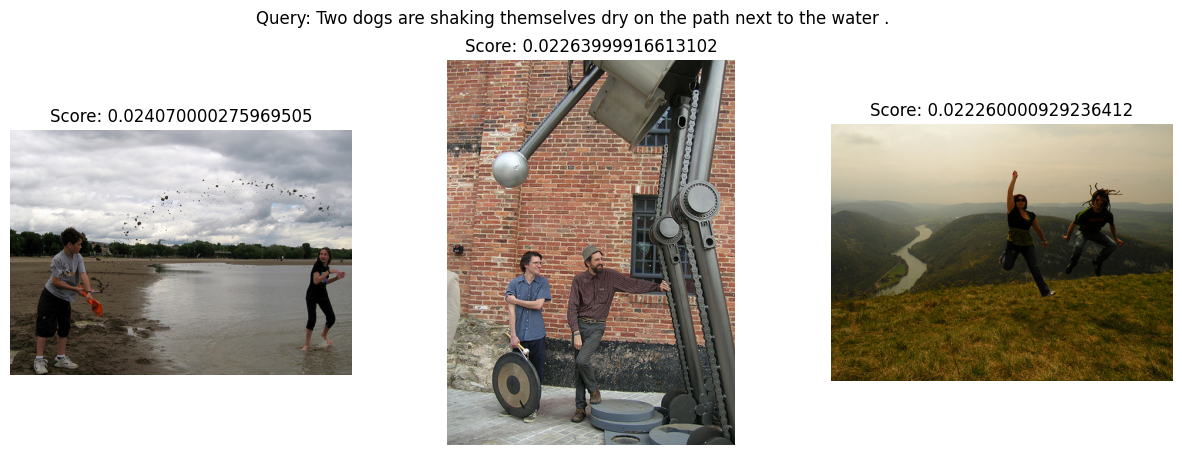

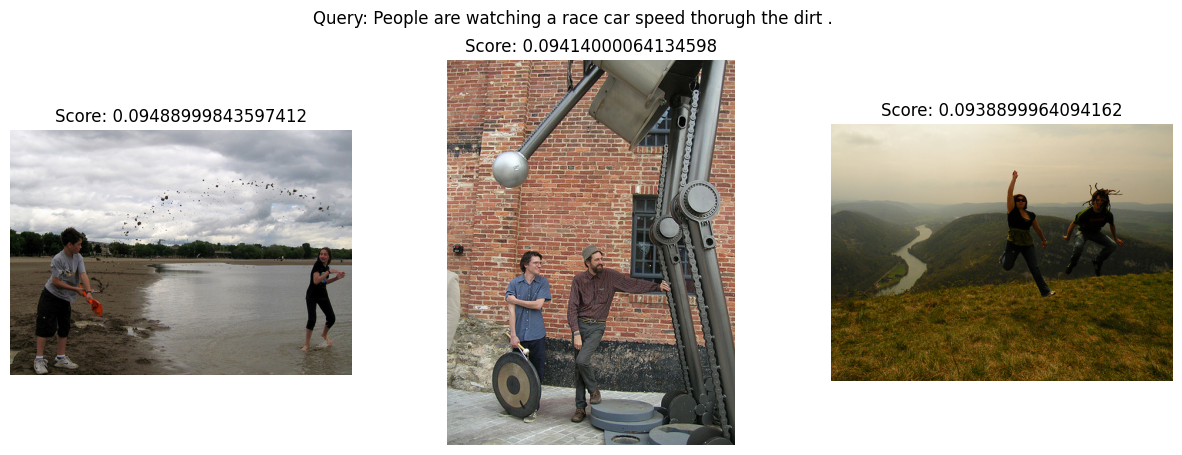

Young boys enjoying a spray of water .

This image is unavailable in your country in compliance with local laws.


A little boy in a green soccer uniform is running on the grass .

This image is unavailable in your country in compliance with local laws.




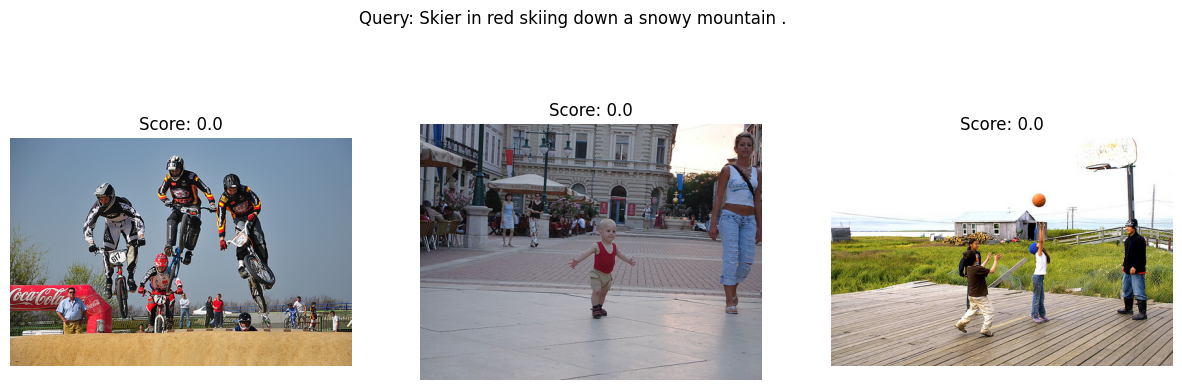

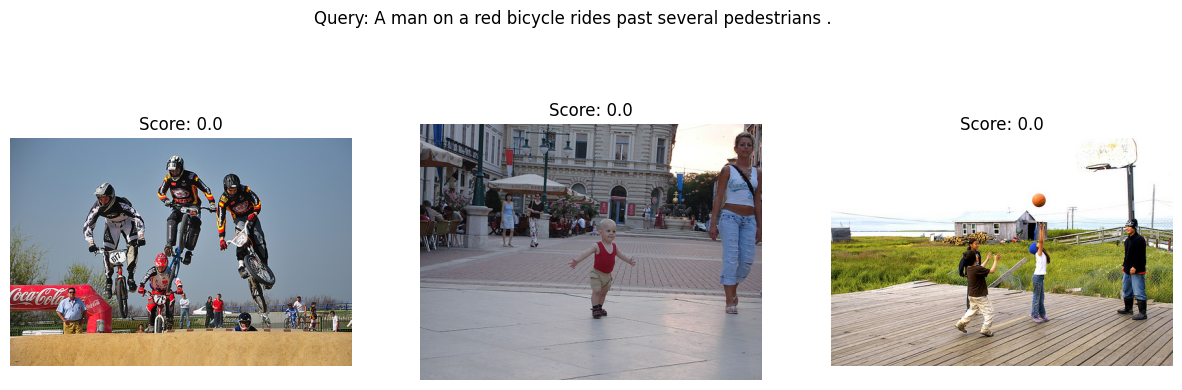

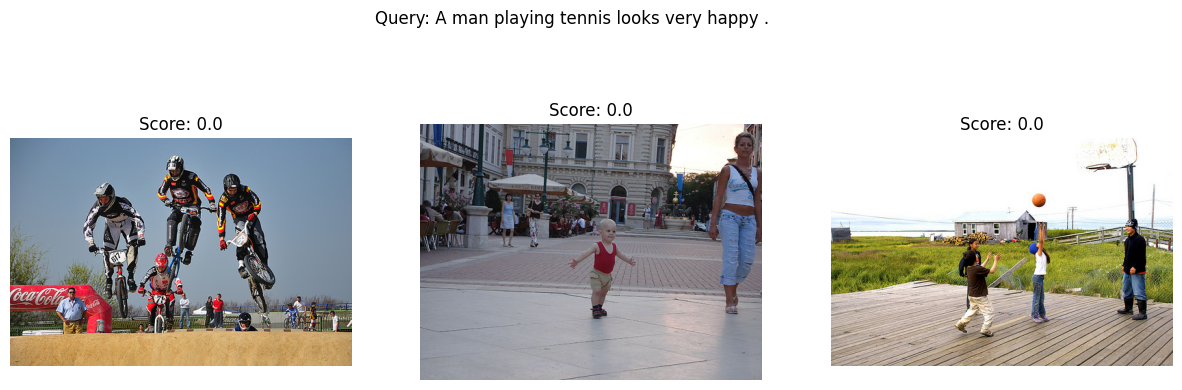

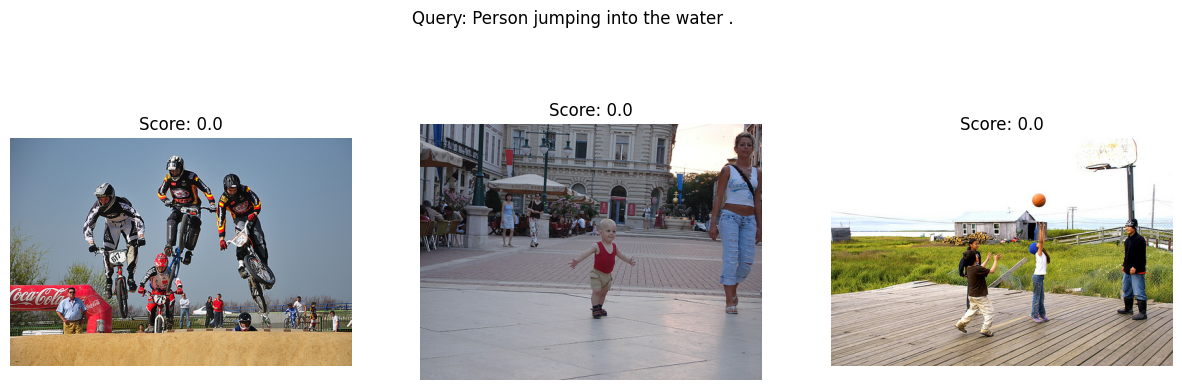

Boy wearing a green and white soccer uniform running through the grass .

This image is unavailable in your country in compliance with local laws.


A toddler boy in a red tank top and khaki shorts walks on the European street with a woman in a white top and faded blue jeans .

This image is unavailable in your country in compliance with local laws.




In [46]:
samples = df_queries.sample(10)
test_queries = list(samples["query_text"])

for query in test_queries:
    find_images_top_k(query)

## Вывод по разделу:

Функция разработана и выводит топ k изображений подходящих по запрос. К сожалению выводятся почти всегда одни и те же изображения но с разным score - то есть модель работает, но качество работы сомнительно. Возможно поможет другие способы векторизации текста (BERT) и изображений?

# Общий вывод

1. Мы загрузили изображения и провели первоначальный анализ:
    - пропусков в данных нет
    - У нас много изображений детей - важность отсеивания для соблюения законов велика
2. Создали аггрегированную оценку из оценок экспертов и крауд-сервиса
    - Если оценка эксперта (expert_score) отсутствует (NaN), используется только оценка людей (share_pos).
    - Если оценка людей отсутствует (NaN), используется только оценка эксперта.
    - Если и то, и другое присутствует, итоговая оценка вычисляется как взвешенная сумма: 60% от оценки эксперта и 40% от оценки людей.
3. Мы подготовили датафрейм для обучения, включающий ключевую информацию: названия файлов с изображениями, текстовые запросы, их идентификационные номера и оценку аггрегированную
4. Отцензурировали тренировочный датасет убрав все запросы связанные с детьми, лематизироавали описания.
5. Выполнили векторизацию изображений с использованием сверточной нейронной сети ResNet-50, состоящей из 50 скрытых слоев:
    - Размер батча установлен на 32. В качестве оптимизатора выбран алгоритм Adam. Функцией потерь будет MSE, а целевой метрикой — MAE.
    - Размерность vectorized_images: (35251, 1)
6. Провели векторизацию текста с помощью предобученой word2vec ("glove-wiki-gigaword-300")
    - Размерность query_vectors: (35251, 300)
7. Использовали разбиение на трейн/тест с помощью GroupShuffleSplit, так как важно избежать утечки информации между обучающей и тестовой выборками.
8. Обучили несколько моделей:
    - Линейная регрессия - Значение метрики MAE по результатам кросс-валидации: 0.14.
    - Метод опорных векторов - лучший результат при параметрах {'C': 0.1, 'epsilon': 1} MAE = 0.09
    - Полносвязная нейронная сеть - лучшее значение MAE на валидационной выборке по эпохам: 0.0813
9. Сделали функцию которая тестирует работу модели на нескольких текстовых описаниях: выводит топ k изображений подходящих по запрос. К сожалению, выводятся почти всегда одни и те же изображения но с разным score - то есть модель работает, но качество работы сомнительно. Возможно поможет другие способы векторизации текста (BERT) и изображений?